In [1]:
import cv2
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
%matplotlib inline
print("complete")
from IPython.display import HTML
from moviepy.editor import *
import math


complete


Distortion Coefficient:  [[ -4.36704121e+00   9.95932047e+00   9.22104545e-02   4.51441551e-02
    1.01267607e+03]]
Calibration Matrix:  [[  4.58577773e+03   0.00000000e+00   5.75017861e+02]
 [  0.00000000e+00   4.64506857e+03   2.88591078e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


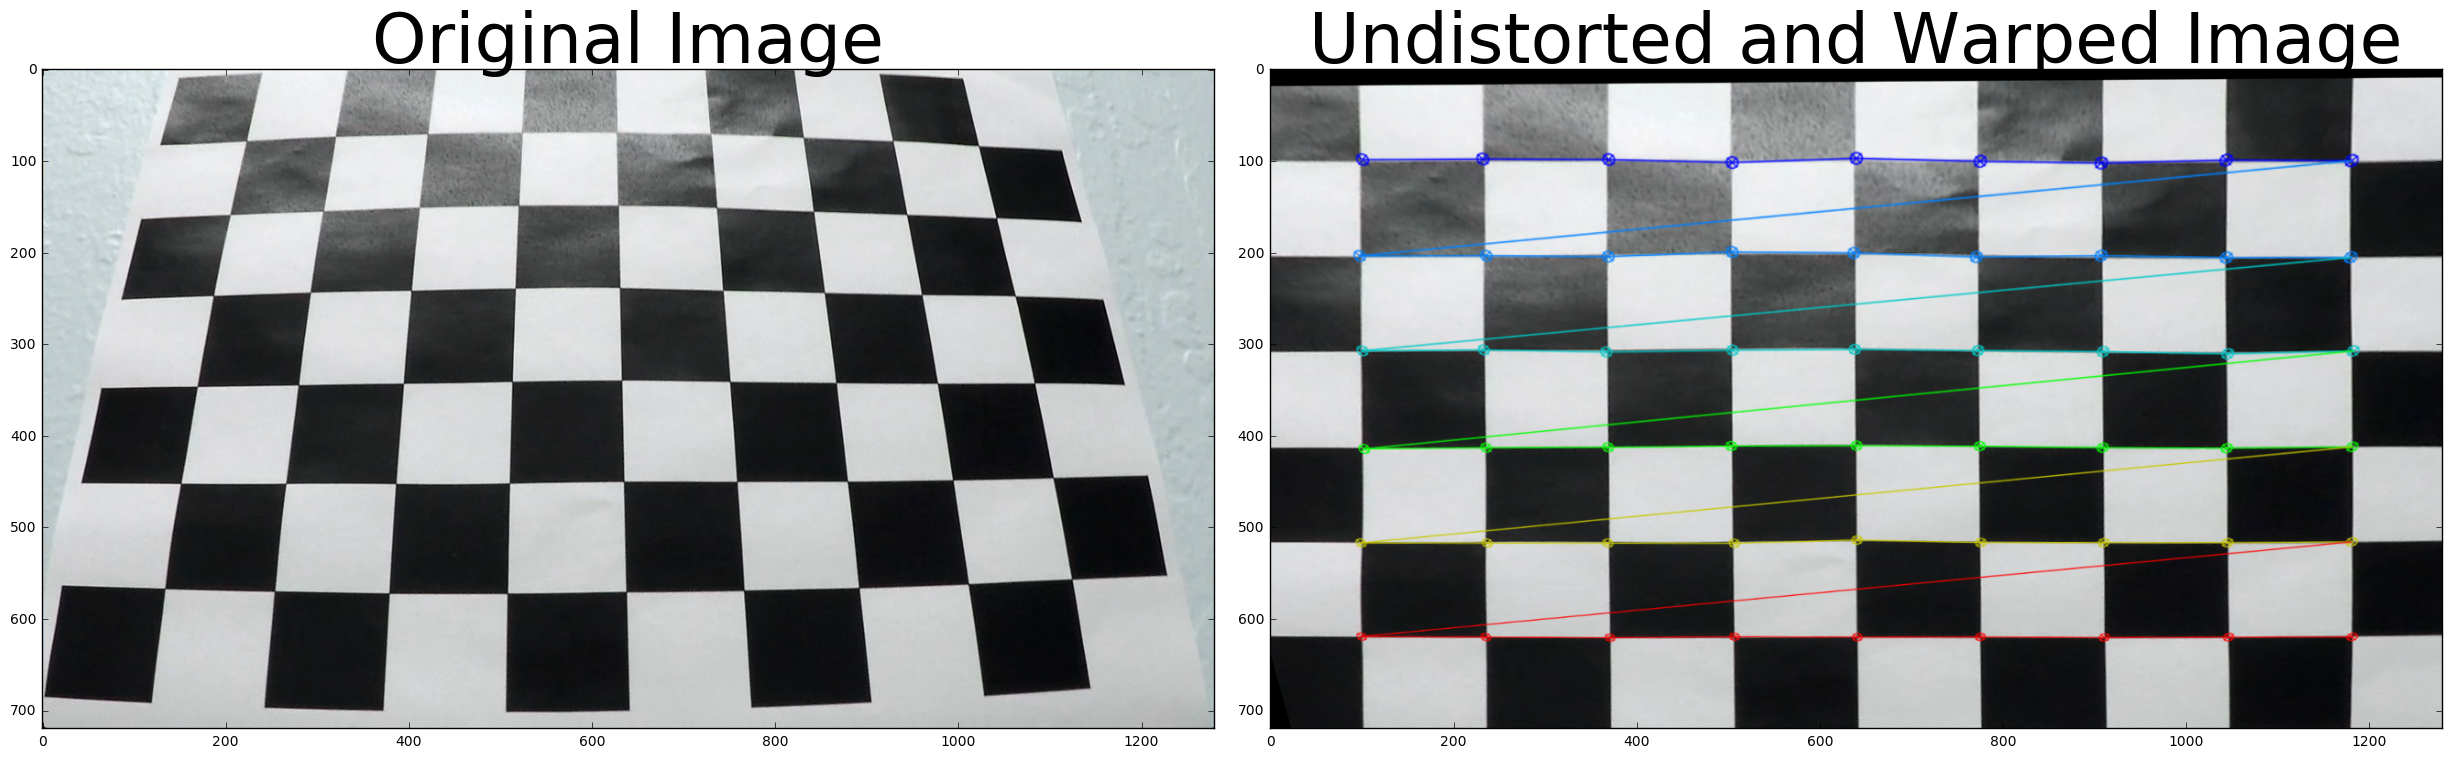

In [2]:
#Load pickled matrix and distortion coefficients. Code for calculating is commented out in the bottom two cells to save time.
#This code visualizes undistortion and unwarping using a chessboard

dist_pickle = pickle.load( open( "camera_cal/distortionpickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
img = cv2.imread('camera_cal/testimage2.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

# pass image through function
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)

#Plot the images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#print distortion coefficients and calibration matrix
print("Distortion Coefficient: ", dist)
print("Calibration Matrix: ", mtx)

In [3]:
# define line class
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = np.array([[False]])
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        self.roc_ave = [500,500,500]
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.flags =  0 

In [21]:
#Load pickled coefficients (so above cell can be skipped)
dist_pickle = pickle.load( open( "camera_cal/distortionpickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
src = np.float32([[570,460],[713,460], [155,705],[1200,705]])
dst = np.float32([[155,100],[870,100], [155,705],[870,705]])
# Use predefined points to get the perspective transform matrix and inverse matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = inv(M)
#Define empty lane lines
LeftL = Line()
RightL = Line()


def undist(img, mtx, dist):
    # undistorts and image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def draw_poly(img):
    # draw polygon image. This is used for testing purposes only.
    #cv2.polylines(image, vertices, isClosed=1,color=[255, 0, 0], thickness=1, lineType=8, shift=0)
    color=[0, 255, 0]
    thickness=4
    cv2.line(img, (659,434), (1115,717), color, thickness)
    cv2.line(img, (1115,717), (196,717), color, thickness)
    cv2.line(img, (196,717), (618,434), color, thickness)
    cv2.line(img, (618,434), (659,434), color, thickness)    
        
def color_shift(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    #transfor image to hls color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    #l_channel = hls[:,:,1] #This channel is not used for calculations
    s_channel = hls[:,:,2]
    
    #Convert image to grayscale for further filtering
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 30
    thresh_max = 100
    # grayscale thresholds
    g_thresh_min = 50
    g_thresh_max = 255
    g_binary = np.zeros_like(gray)
    g_binary[(gray >= g_thresh_min) & (gray <= g_thresh_max)] = 1
    
    #get gradient binary image
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max) & (g_binary ==1)] = 1

    # Threshold s color channel
    s_thresh_min = 100
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Threshold h color channel
    h_thresh_min = 15
    h_thresh_max = 70
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh_min) & (h_channel <= h_thresh_max)] = 1
    
    # Threshold gray color channel for color
    g_thresh_min = 160
    g_thresh_max = 255
    g_binary2 = np.zeros_like(gray)
    g_binary2[(gray >= g_thresh_min) & (gray <= g_thresh_max)] = 1
    
    # generate hsg binary values
    hsg_binary = np.zeros_like(s_channel)
    hsg_binary[(h_binary == 1) & (s_binary ==1) & (g_binary2== 1)] = 1
    
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    # combine binary thresholds and set to 255 for visualization
    combined_binary[(hsg_binary == 1) | (sxbinary == 1)] = 255
    #combined_binary[(hsg_binary == 1) | (sxbinary == 1)] = 1    

    # used for testing
    #color_binary = np.dstack((combined_binary, combined_binary, combined_binary))


    return combined_binary

def warper(img, M):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

def region_of_interest(img, vertices, in_vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    #in_mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
        blank = (0,0,0)
    else:
        ignore_mask_color = 255
        blank = 0
        
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    # remove unwanted pixels in between lane lines
    cv2.fillPoly(img, in_vertices, blank)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def find_lines(img):
    #Stack image into 3 channels
    out_img = np.dstack((img, img, img))
    # Identify the x and y positions of all nonzero pixels in the image
    if(LeftL.allx == None):
        histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(img.shape[0]/nwindows)
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image #Use for visualization if needed
            #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        X_left = nonzerox[left_lane_inds]
        Y_left = nonzeroy[left_lane_inds] 
        X_right = nonzerox[right_lane_inds]
        Y_right = nonzeroy[right_lane_inds] 
        if(X_left != [] and X_right != [] and Y_right != [] and Y_left != []):
            left_fit = np.polyfit(Y_left, X_left, 2)
            LeftL.current_fit = [left_fit]
            right_fit = np.polyfit(Y_right, X_right, 2)
            RightL.current_fit = [right_fit]
        else: 
            left_fit = [0,0,0]
            right_fit = [0,0,0]
            print("no initial lane lines found")
        # Fit polynomial coefficients into lane lines
        fity = np.linspace(0, img.shape[0]-1, img.shape[0] )
        fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
        LeftL.allx = fit_leftx
        fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]
        RightL.allx = fit_rightx
        RightL.ally = LeftL.ally = fity
        
    # If previous lines found, skip the sliding window step
    else: 
        #return all non-zero points
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        ind = len(LeftL.current_fit)-1
        left_fit = np.array(LeftL.current_fit[ind])
        right_fit = np.array(RightL.current_fit[ind])
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        if(leftx != [] and lefty != [] and rightx != [] and righty != []):
            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            
            # find average polynomial coefficients - not using for now
            """if(len(LeftL.current_fit) > 4):
                LeftL.best_fit = np.mean(LeftL.current_fit[len(LeftL.current_fit)-5:len(LeftL.current_fit-1)], axis=0)
                RightL.best_fit = np.mean(RightL.current_fit[len(RightL.current_fit)-5:len(RightL.current_fit-1)], axis=0)
            """
            # Calculate percentage difference between last fit and current fit for last coefficient
            perdif_L = abs((LeftL.current_fit[ind]-left_fit)/LeftL.current_fit[ind])*100
            perdif_R = abs((RightL.current_fit[ind]-right_fit)/RightL.current_fit[ind])*100
            # discard false lane line a maximum of 1 time. 
            if(perdif_L[2] < 15 or LeftL.detected == False):
                LeftL.current_fit = np.append(LeftL.current_fit, [left_fit], axis=0)
                LeftL.detected = True
            else:
                left_fit = LeftL.current_fit[ind]
                LeftL.flags += 1
                LeftL.detected = False
            if(perdif_R[2] < 15  or RightL.detected == False):
                RightL.current_fit = np.append(RightL.current_fit, [right_fit], axis=0)
                RightL.detected = True
            else:
                right_fit = RightL.current_fit[ind]
                RightL.flags += 1
                RightL.detected = False
        
        # fit coefficients to lines
        fity = np.linspace(0, img.shape[0]-1, img.shape[0] )
        fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
        LeftL.allx = fit_leftx
        fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]
        RightL.allx = fit_rightx
        LeftL.ally = RightL.ally = fity

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    window_img = np.zeros_like(out_img)
    margin = margin/3
    left_line_window1 = np.array([np.transpose(np.vstack([fit_leftx-margin, fity]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_leftx+margin, fity])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([fit_rightx-margin, fity]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_rightx+margin, fity])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,0,0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (255,0,0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.9, 0)
    
    # use to visualize lines
    """plt.imshow(result)
    plt.plot(fit_leftx, fity, color='yellow')
    plt.plot(fit_rightx, fity, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    """
    #return the image with lines drawn
    return  result

def rad_curve():
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval_left = np.max(LeftL.ally)
    y_eval_right = np.max(RightL.ally)
    #ind = len(LeftL.current_fit)-1
    
    # load coefficeints and line values
    left_fit = np.array(LeftL.current_fit[-1])
    right_fit = np.array(RightL.current_fit[-1])
    leftx = LeftL.allx
    rightx = RightL.allx
    ploty = LeftL.ally
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    #calculate radius of curvature in pixel space
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    #Use code below to visualize curves
    """mark_size = 3
    plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
    plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.plot(left_fitx, ploty, color='green', linewidth=3)
    plt.plot(right_fitx, ploty, color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images
    """
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    LeftL.radius_of_curvature = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    RightL.radius_of_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m

def pipeline(img):
    # undistort image
    undistorted = undist(img, mtx, dist)
    # get a binary masked image
    recolored = color_shift(undistorted) 
    
    # define vertices to remove unwanted pixels
    vertices = np.array([[(200,689),(600, 430), (699, 430), (1160,689)]], dtype=np.int32)
    in_vertices = np.array([[(369,681),(599, 506), (710, 506), (1000,681)]], dtype=np.int32) 
    # remove unwanted image area
    maskedimg = region_of_interest(recolored, vertices, in_vertices)
    #draw_poly(maskedimg)
    # apply perspective transform
    warped = warper(maskedimg, M)
    # find lane lines
    warped2 = find_lines(warped)
    #find radius of curvature
    rad_curve()

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([LeftL.allx, LeftL.ally]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([RightL.allx, RightL.ally])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(warped2, np.int_([pts]), (0,102,203))
    
    # Assume camera is in the center. Subtract to get base position and convert to meters (3.7/700 = Xmeters)
    LeftL.base_pos = (warped2.shape[1]/2 - pts_left[0][-1][0])*3.7/700
    RightL.base_pos = (pts_right[0][-1][0] - warped2.shape[1]/2)*3.7/700
    # Find how far the car is from center of lane. Generate a string to display position from center
    amount_off = (RightL.base_pos - LeftL.base_pos)
    
    if(amount_off < 0):
        amount_off = "%.2f" % abs(amount_off)
        base_string = 'Vehicle is: ' + str(amount_off) + 'm Right of Center'
    else:
        amount_off = "%.2f" % amount_off
        base_string = 'Vehicle is: ' + str(amount_off) + 'm Left of Center'
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warped2, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    

    # display radius of curvature and amount off center
    font = cv2.FONT_HERSHEY_SIMPLEX
    #curvature = "%.1f" % ((LeftL.radius_of_curvature + RightL.radius_of_curvature)/2)
    LeftL.roc_ave = [LeftL.roc_ave[1], LeftL.roc_ave[2], LeftL.radius_of_curvature]
    RightL.roc_ave = [RightL.roc_ave[1], RightL.roc_ave[2], RightL.radius_of_curvature]
    curvature = "%.1f" % min(sum(LeftL.roc_ave)/3,sum(RightL.roc_ave)/3)
    #curvature = "%.1f" % min(LeftL.radius_of_curvature, RightL.radius_of_curvature)

    
    cv2.putText(result,'Radius of Curvature: ' + str(curvature) + 'm',(10,100), font, 1,(255,255,255),1,cv2.LINE_AA)
    cv2.putText(result, base_string, (10,40), font, 1,(255,255,255),1,cv2.LINE_AA)

    
    return result



done


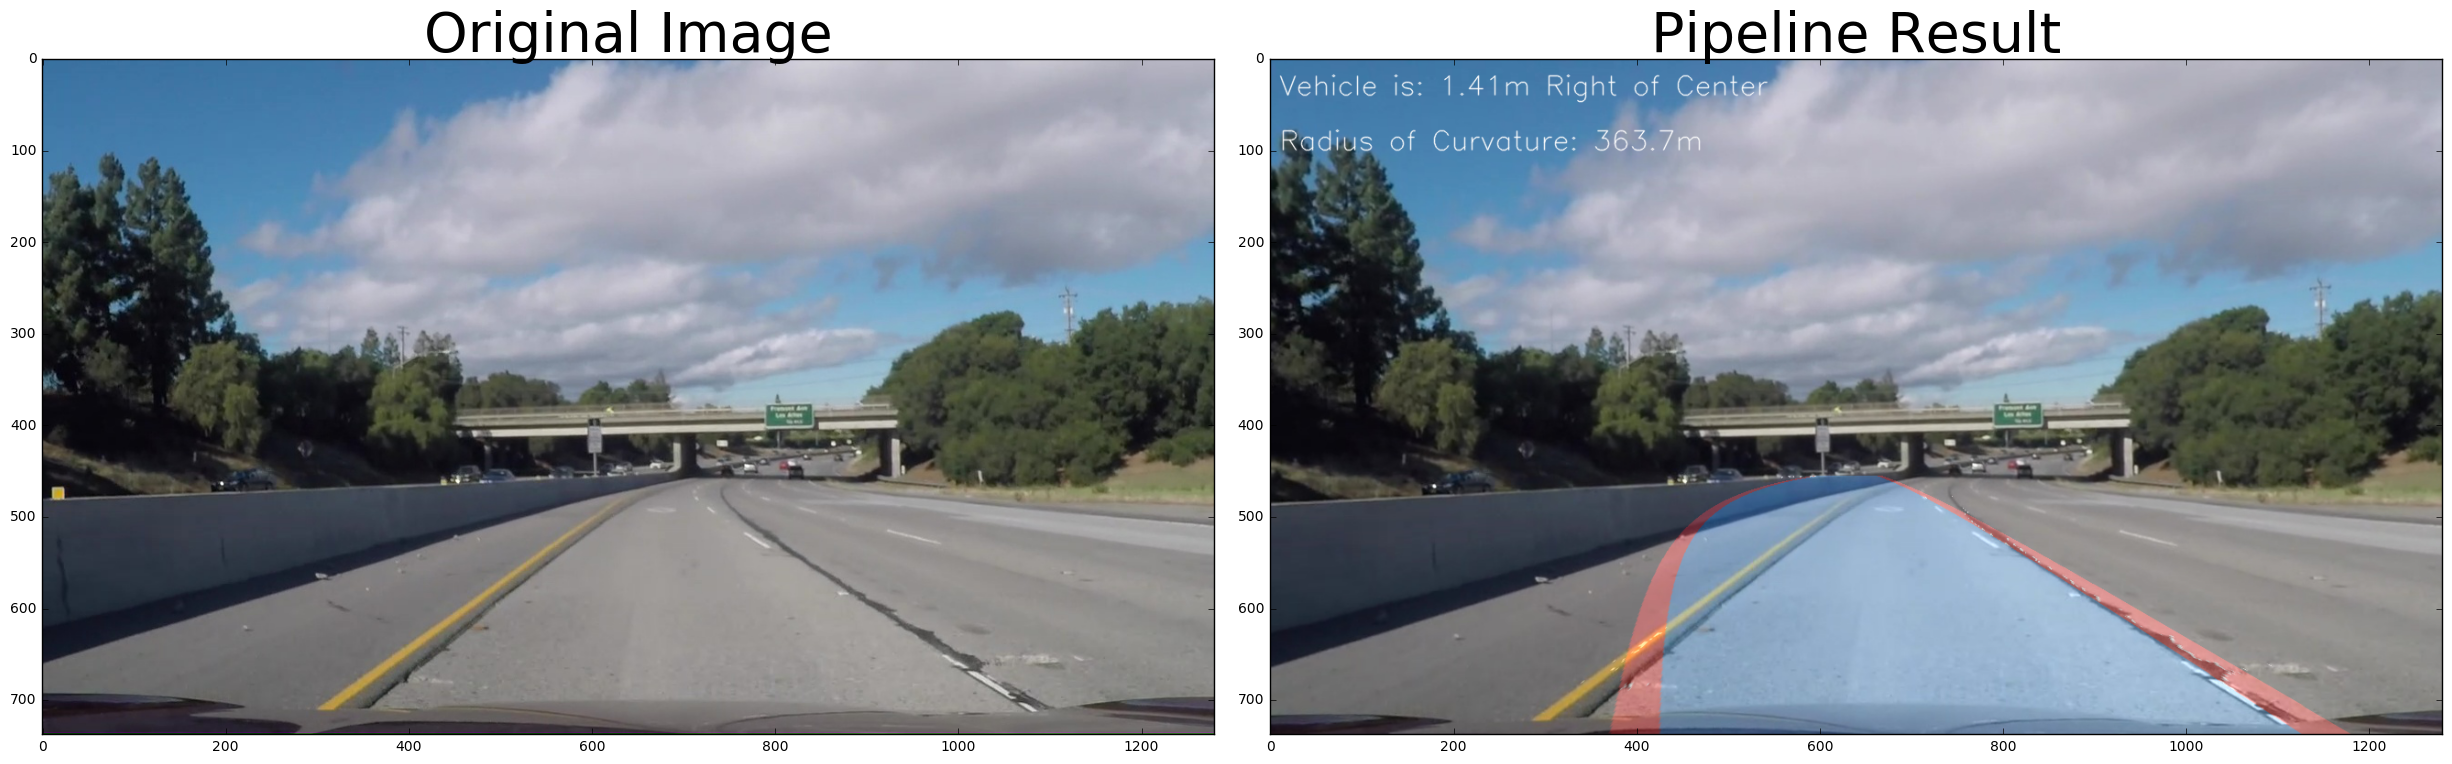

In [22]:
# cell block for testing with images.


for i in range(13,14):
    #string = 'test_images/test' + str(i) + '.jpg'
    if(i <10):
        string = 'Problems/scene0000' + str(i) + '.jpg'
    else:
        string = 'Problems/scene000' + str(i) + '.jpg'
    img = mpimg.imread(string)

    result = pipeline(img)
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    #draw_poly(masked, src)
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=40)
    

    ax2.imshow(result)#, cmap = 'gray')
    
    ax2.set_title('Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

print("done")

In [23]:
#Test using video

yellow_output = 'projectoutput.mp4'
#problems = 'problems.mp4'
clip2 = VideoFileClip('project_video.mp4')
yellow_clip = clip2.fl_image(pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)
#%time clip2.write_videofile(problems, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

[MoviePy] >>>> Building video projectoutput.mp4
[MoviePy] Writing video projectoutput.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:53<00:00,  7.37it/s]  0%|                                                                                 | 1/1261 [00:00<02:51,  7.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: projectoutput.mp4 

Wall time: 2min 55s
